<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)" data-toc-modified-id="Using-percent-served-to-convert-from-sentences-to-lengths-of-stay-(LOS)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using percent served to convert from sentences to lengths of stay (LOS)</a></span></li></ul></li><li><span><a href="#Cleaning-validation" data-toc-modified-id="Cleaning-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cleaning validation</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This is the one notebook in VA that actually starts with raw scraped data. The part that imports raw data is commented out because it takes a long time to run and you only need to do it once, and we saved the output of that so unless you're tryna change it up you can just import the result. The second half that's not commented out is the same preprocessing that gets copied into most of our modeling notebooks that use the data we scraped in October 2021.

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

# Data cleaning
You can skip the commented out cells.

In [2]:
# court_data = pd.read_csv('../state/VA/VA_data/deduped_va_court_data.csv')
# court_data['time_step'] = (court_data.year - 2010) * 12 + court_data.month + round(court_data.day / 365 * 12)

In [49]:
# sdc_data = pd.concat([
#     pd.read_csv(
#         f'../state/VA/VA_data/VA_circuit_data/letter_data_test_{i}.csv',
#         index_col=0
#     ) for i in range(18)
# ])

# print('number of null disposition dates: ', sdc_data['Disposition Date'].isnull().sum())
# sdc_data['time_step'] = sdc_data['Disposition Date'].fillna(sdc_data['Filed'])

# sdc_data = sdc_data[sdc_data.index != -1]
# sdc_data = sdc_data[sdc_data.Charge.notnull() & sdc_data['Code Section'].notnull()]

# sdc_data = sdc_data[sdc_data['Disposition Code'] == 'Guilty'].drop('Disposition Code', axis=1)


# sdc_data['day'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[1]))
# sdc_data['month'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[0]))
# sdc_data['year'] = sdc_data.time_step.apply(lambda x: int(x.split('/')[2]))
# sdc_data.time_step = sdc_data.month + sdc_data.year * 12 + sdc_data.day / 365 * 12 - 2010 * 12

# sdc_data['sentence_time'] = sdc_data['Sentence Time'].fillna('0')
# sdc_data['sentence_suspended'] = sdc_data['Sentence Suspended'].fillna('0')

# def clean_sentence_length(sentence_str):
#     sentence = 0
#     for date in sentence_str.split('(s)'):
#         if 'Year' in date:
#             sentence += float(date.split(' ')[0]) * 12
#         if 'Month' in date:
#             sentence += float(date.split(' ')[0])
#         if 'Day' in date:
#             sentence += float(date.split(' ')[0]) / 365 * 12
#     return sentence

# sdc_data['person_id'] = sdc_data.Defendant + sdc_data.DOB + sdc_data.Address

# sdc_data['compartment_duration'] = \
#     sdc_data.sentence_time.apply(clean_sentence_length) - sdc_data.sentence_suspended.apply(clean_sentence_length)


# sdc_data = sdc_data.rename({
#     'Code Section': 'CodeSection', 'Concurrent/Consecutive': 'ConcurrentConsecutive'
# }, axis=1)

# sdc_data = sdc_data[sdc_data.index != 1]
# sdc_data = sdc_data.drop_duplicates()

# sdc_data.head()

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:336

number of null disposition dates:  138519


,Address,Amended Charge,Amended Charge Type,Amended Code Section,Arrest Date,Charge,Charge Type,Class,CodeSection,Commenced by,Concluded By,ConcurrentConsecutive,Costs,Court/DMV Surrender,DOB,Defendant,Disposition Date,Driver Improvement Clinic,Driving Restrictions,Filed,Fine Amount,Fines/Cost Paid,Jail/Penitentiary,Life/Death,Locality,Military,Offense Date,Operator License Suspension Time,Probation Starts,Probation Time,Probation Type,Program Type,Race,Restitution Amount,Restitution Paid,Sentence Suspended,Sentence Time,Sex,Traffic Fatality,VA Alcohol Safety Action,county,time_step,day,month,year,sentence_time,sentence_suspended,person_id,compartment_duration
0,SURRY[.] VA 23883,NaN,NaN,NaN,05/14/2020,OTHER FAIL TO REGIST[.] 2ND OFF,Felony,6,18.2-472.1,Indictment,Guilty Plea,NaN,$535.00,NaN,06/19/****,ABNEY[.] JUSTIN EUGENE,09/01/2021,NaN,NaN,03/18/2021,$0.00,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,01/29/2020,NaN,NaN,NaN,NaN,NaN,White,$0.00,NaN,5 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,141.032877,1,9,2021,5 Year(s),5 Year(s),ABNEY[.] JUSTIN EUGENE06/19/****SURRY[.] VA 23883,0.0
4,PETERSBURG[.]VA 23803,ACCOMODATION,Felony,18.2-248,NaN,DISTRIBUTE CLASS II DRUG,Felony,NaN,18.2-248,Direct Indictment,Guilty Plea,NaN,NaN,NaN,08/22/****,ADDISON[.] BOB IRVIN; JR,02/07/2007,NaN,NaN,09/25/2006,NaN,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,12/09/2004,NaN,NaN,99 Year(s)0 Month(s)0 Day(s),Supervised,NaN,White,NaN,NaN,5 Year(s),5 Year(s),Male,NaN,NaN,Surry Circuit Court,-33.769863,7,2,2007,5 Year(s),5 Year(s),ADDISON[.] BOB IRVIN; JR08/22/****PETERSBURG[....,0.0
8,HAMPTON[.] VA 23669,NaN,NaN,NaN,07/09/2018,ASSAULT,Misdemeanor,1,18.2-57,General District Court Appeal,Trial - Judge With Witness,NaN,$53.00,NaN,05/08/****,ADKINSON[.] ERICA ANTRIVIA,02/06/2019,NaN,NaN,10/02/2018,$0.00,Yes,Jail,NaN,COMMONWEALTH OF VA,NaN,07/08/2018,NaN,NaN,NaN,NaN,NaN,Black,NaN,NaN,3 Month(s),6 Month(s),Female,NaN,NaN,Surry Circuit Court,110.197260,6,2,2019,6 Month(s),3 Month(s),ADKINSON[.] ERICA ANTRIVIA05/08/****HAMPTON[.]...,3.0
10,HOPEWELL[.] VA 23860,NaN,NaN,NaN,10/09/2018,ENTER HOUSE TO COMMIT A&B ETC.,Felony,U,18.2-91,Indictment,Trial - Judge With Witness,NaN,$800.00,NaN,03/26/****,ALLEN[.] CHRISTOPHER T,11/06/2019,NaN,NaN,01/08/2019,$0.00,NaN,Penitentiary,NaN,COMMONWEALTH OF VA,NaN,08/25/2018,NaN,NaN,NaN,NaN,NaN,White,$12791.56,NaN,6 Year(s)6 Month(s),10 Year(s),Male,NaN,NaN,Surry Circuit Court,119.197260,6,11,2019,10 Year(s),6 Year(s)6 Month(s),ALLEN[.] CHRISTOPHER T03/26/****HOPEWELL[.] VA...,42.0
12,ELBERON VA 23846,PETIT LARCENY,Misdemeanor,18.2-96,09/01/2007,BREAK AND ENTER,Felony,NaN,18.2-91,Indictment,Guilty Plea,NaN,$657.00,NaN,03/26/****,ALLEN[.] CHRISTOPHER THOMAS,08/05/2009,NaN,NaN,10/17/2007,$2500.00,NaN,Jail,NaN,COMMONWEALTH OF VA,NaN,08/29/2007,NaN,NaN,NaN,NaN,NaN,White,$100.00,NaN,12 Month(s),12 Month(s),Male,NaN,NaN,Surry Circuit Court,-3.835616,5,8,2009,12 Month(s),12 Month(s),ALLEN[.] CHRISTOPHER THOMAS03/26/****ELBERON V...,0.0


## Using percent served to convert from sentences to lengths of stay (LOS)
This disaggregates by the crime types given to us in the LOS table. You may need to disaggregate differently for whatever policy you're working on, you'll have to think about how to capture the average LOS in whatever categories you work with.

In [50]:
# #CONSPIRACY
# sdc_data['CONSPIRACY'] = sdc_data.Charge.apply(
#     lambda x: any([i in x for i in [
#         'CONSP'
#     ]])
# )

# #MURDER

# murder_crime_codes = ['18.2-31', '18.2-32', '18.2-33']

# first_degree_terms = ['1ST DEG', 'FIRST DEG']
# capital_terms = ['CAP'] # and not 'MURDER: NON CAPITAL FELONY'
# second_degree_terms = ['2ND DEG', 'SECOND DEG']

# sdc_data['FIRST_DEGREE_MURDER'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
#     sdc_data.Charge.apply(lambda x: any([i in x for i in first_degree_terms])) &
#     (~sdc_data.CONSPIRACY)
# )
# sdc_data['SECOND_DEGREE_MURDER'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
#     sdc_data.Charge.apply(lambda x: any([i in x for i in second_degree_terms])) &
#     (~sdc_data.CONSPIRACY)
# )
# sdc_data['CAPITAL_MURDER'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])) &
#     sdc_data.Charge.apply(lambda x: any([i in x for i in capital_terms]) 
#                             and not any([i in x for i in ['NON-CAP', 'NON CAPITAL']])) &
#     (~sdc_data.CONSPIRACY)
# )
# sdc_data['OTHER_MURDER'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in murder_crime_codes])
#                                  and not any([i in x for i in ['18.2-312', '18.2-311']])) &
#     (~sdc_data.CAPITAL_MURDER) &
#     (~sdc_data.FIRST_DEGREE_MURDER) &
#     (~sdc_data.SECOND_DEGREE_MURDER) &
#     (~sdc_data.CONSPIRACY)
# )
# #DRUG CRIMES
# drug_crimes = ['18.2-248', '18.2-250', '18.2-251',  '18.2-255', '18.2-257', '18.2-258', '18.2-260', '18.2-262', 
#                  '18.2-264', '18.2-265']

# sdc_data['DRUG_POSSESSION'] = (
#     sdc_data.Charge.apply(lambda x: any([i in x for i in ['POSS','PWID']])) &
#     (~sdc_data.CONSPIRACY)
# )
# sdc_data.DRUG_POSSESSION = sdc_data.DRUG_POSSESSION & (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
# )

# sdc_data['DRUG_SALE'] = (
#     sdc_data.Charge.apply(lambda x: any([i in x for i in [
#         'DISTRB',
#         'DISTRIB',
#         'DIST', 
#         'SALE',
#         'SELL'
#     ]])) &
#     (~sdc_data.CONSPIRACY)
# )

# sdc_data.DRUG_SALE = (sdc_data.DRUG_SALE) & (~sdc_data.DRUG_POSSESSION) & (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes]))
# )

# sdc_data['DRUG_OTHER'] = (~sdc_data.DRUG_SALE) & (~sdc_data.DRUG_POSSESSION) & (~sdc_data.CONSPIRACY) & (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in drug_crimes])) 
    
# )


# # ARSON
# ars_crime_codes = ['18.2-77', '18.2-79', '18.2-80',  '18.2-81', '18.2-82', '18.2-83', '18.2-84', '18.2-85', '18.2-86', 
#                  '18.2-87', '18.2-88']

# sdc_data['ARSON'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in ars_crime_codes])) &
#     (~sdc_data.CONSPIRACY)
# )


# # SEX OFFENSE
# s_crime_codes = ['18.2-346', '18.2-347', '18.2-348',  '18.2-349', '18.2-355', '18.2-356', '18.2-357', '18.2-361', 
#                  '18.2-362', '18.2-365', '18.2-366', '18.2-368', '18.2-370']

# sdc_data['SEX_OFFENSE'] = (
#     (sdc_data.CodeSection.apply(lambda x: any([i in x for i in s_crime_codes])))  &
#     (~sdc_data.CONSPIRACY)
# )

# # DWIs
# dwi_crime_codes = ['18.2-272', '18.2-266', '18.2-270', '46.2-341.28', '46.2-341.24', '46.2-341.26', '18.2-268', 
#                    '18.2-272']

# sdc_data['DWI'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in dwi_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )

# #WPN
# weapons_crime_codes = ['18.2-279', '18.2-280', '18.2-281', '18.2.282', '18.2-283', '18.2-284', '18.2-285', 
#                        '18.2-286', '18.2-287', '18.2-289', '18.2-290', '18.2-294', '18.2-295', '18.2-300', 
#                        '18.2-304', '18.2-308', '18.2-309', '18.2-311', '18.2-312', '52-52', '53.1-203(4)',
#                        '53.1-203(7)', '18.2-56.1', '18.2-56.2']

# sdc_data['WEAPON'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in weapons_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )


# #BUR
# burglary_crime_codes = ['18.2-93', '18.2-92', '18.2-89', '18.2-90', '18.2-91', '18.2-94']

# sdc_data['BURGLARY'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in burglary_crime_codes]))   &
#     (~sdc_data.CONSPIRACY)
# )


# #ROB
# robbery_crime_codes = ['18.2-58']
# sdc_data['ROBBERY'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in robbery_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )

# # LARCENY
# l_crime_codes = ['18.2-23', '18.2-95', '18.2-96',  '18.2-97', '18.2-98', '18.2-100', '18.2-101', '18.2-102', 
#                  '18.2-103', '18.2-105', '18.2-107', '18.2-108',  '18.2-109', '18.2-111', '18.2-112', '18.2-113'
#                 '18.2-114', '18.2-115', '18.2-116', '18.2-117',  '18.2-118', '19.2-361', '18.2-113',
#                 '55.1-2838', '55.1-2839', '55.1-2840', '18.2-117',  '18.2-118', '18.2-178', '19.2-361']
# sdc_data['LARCENY'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in l_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )


# # ASSAULT
# a_crime_codes = ['18.2-41', '18.2-42', '18.2-45',  '18.2-51', '18.2-52', '18.2-53', '18.2-54', '18.2-55', '18.2-56', 
#                  '18.2-57']
# sdc_data['ASSAULT'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in a_crime_codes])
#                                  and not any([i in x for i in ['18.2-56.2', '18.2-56.1']]))  &
#     (~sdc_data.CONSPIRACY)
# )

# # RAPE
# r_crime_codes = ['18.2-61', '18.2-63', '18.2-64', '18.2-67']
# sdc_data['RAPE'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i in x for i in r_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )


# # KIDNAPPING
# kidnapping_crime_codes = ['18.2-47', '18.2-48', '18.2-49', '18.2-50', '18.2-48.1', '18.2-49.1']
# sdc_data['KIDNAPPING'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i == x for i in kidnapping_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )
    

# # MANSLAUGHTER 
# manslaughter_crime_codes = ['18.2-35', '18.2-36', '18.2-36.1', '18.2-36.2']
# sdc_data['MANSLAUGHTER'] = (
#     sdc_data.CodeSection.apply(lambda x: any([i == x for i in manslaughter_crime_codes]))  &
#     (~sdc_data.CONSPIRACY)
# )



In [ ]:
# sdc_data.Costs = sdc_data.Costs.fillna('$0').apply(lambda x: float(x[1:]))
# sdc_data['Restitution Amount'] = sdc_data['Restitution Amount'].fillna('$0').apply(lambda x: float(x[1:]))
# sdc_data['Restitution Paid'] = sdc_data['Restitution Paid'].fillna('$0').apply(lambda x: float(x[1:]))


In [51]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [52]:
# # Deduplicate by hearing date (this is the one that takes forever)
# # As written, each row will have row[crime], which is True if most serious offense is said crime, and 
# # row[crime_ANY], which is True if any offense is said crime.

# def get_most_serious_case(df):
#     sorted_crimes = df.sort_values('compartment_duration')
#     most_serious_crime = sorted_crimes.iloc[-1]
#     most_serious_crime['crimes'] = len(df)
#     for crime in crime_types:
#         most_serious_crime[f'{crime}_ANY'] = df[crime].any()
    
#     sorted_crimes = sorted_crimes.iloc[:-1]
#     sorted_crimes.ConcurrentConsecutive = sorted_crimes.ConcurrentConsecutive.map(
#         {'Consecutive': 1, 'Concurrent': 0}
#     ).fillna(0)
#     most_serious_crime['total_sentence_months'] = most_serious_crime.compartment_duration + \
#         (sorted_crimes.ConcurrentConsecutive * sorted_crimes.compartment_duration).sum()
    

#     return most_serious_crime

# sdc_data = sdc_data.groupby(['person_id', 'time_step'], as_index=False).apply(get_most_serious_case)

In [53]:
# def check_for_crime_type(x, crime_type):
#     if x[crime_type]:
#         return crime_type
#     return x['crime_type']
        
# sdc_data['crime_type'] = None
# for crime_type in crime_types:
#     sdc_data['crime_type'] = sdc_data.apply(lambda x: check_for_crime_type(x, crime_type), axis=1)

1.029095043991294

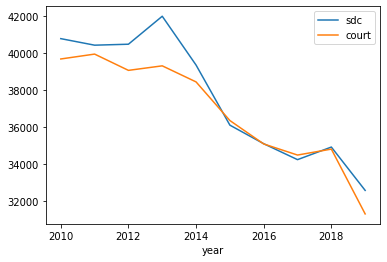

In [54]:
# sdc_overlap = sdc_data[(sdc_data.time_step > 0) & (sdc_data.time_step < 120)]
# court_overlap = court_data[(court_data.time_step > 0) & (court_data.time_step < 120)]

# display_df = pd.DataFrame()
# display_df['sdc'] = sdc_overlap.groupby('year').count().max(axis=1)
# display_df['court'] = court_overlap.groupby('year').count().max(axis=1)
# display_df.iloc[1:].plot()
# MISSING_SCRAPED_DATA_SCALE_FACTOR = display_df.sdc.sum() / display_df.court.sum()
# MISSING_SCRAPED_DATA_SCALE_FACTOR

In [58]:
# for i in range(8):
#     sdc_data.iloc[i * 133952: (i + 1) * 133952].to_csv(f'circuit_data_{i}.csv')

In [60]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,24) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Cleaning validation
Remaining cleaning todos:
* check to see if crime type percentages match the ETC excel sheet 
* check LOS of missed crimes to LOS of caught crimes, if missed crimes are statistically different, that's problem

In [33]:
# This is to compare population to population in terms of breakdown in the data vs in the excel sheet
# --> they mostly line up pretty well!

LOS_data = court_data.groupby('crime_type').mean().total_sentence_months
crime_type_counts = court_data.groupby('crime_type').count().total_sentence_months
crime_type_counts * LOS_data / np.dot(crime_type_counts, LOS_data)

crime_type
ARSON                   0.005177
ASSAULT                 0.143358
BURGLARY                0.062174
CAPITAL_MURDER          0.010521
CONSPIRACY              0.003471
DRUG_OTHER              0.042558
DRUG_POSSESSION         0.090372
DRUG_SALE               0.105417
DWI                     0.021677
FIRST_DEGREE_MURDER     0.062288
KIDNAPPING              0.025742
LARCENY                 0.112850
MANSLAUGHTER            0.007296
OTHER_MURDER            0.023223
RAPE                    0.106514
ROBBERY                 0.081753
SECOND_DEGREE_MURDER    0.011254
SEX_OFFENSE             0.010185
WEAPON                  0.074170
Name: total_sentence_months, dtype: float64

In [17]:
# Check for crime codes that aren't being caught right now...
missing = court_data[court_data.apply(lambda x: all([not x[crime] for crime in crime_types]), axis=1)]
missing.groupby('CodeSection').count().sort_values('HearingDate', ascending=False).iloc[:300]

,Unnamed: 0,HearingDate,HearingResult,HearingType,Filed,Commencedby,Charge,ChargeType,Class,JailPenitentiary,ConcurrentConsecutive,SentenceTime,SentenceSuspended,ProbationType,ProbationTime,ProbationStarts,AppealedDate,person_id,effective_sentence_months,day,month,year,ASSAULT_ON_POLICE,THIRD_DWI_10YR,DRUG_INTENT,DRUG_SALE,2ND,SECOND_PWID,FELON_GUN_POSS,3RD,THIRD_PWID,FOURTH_DWI_10YR,PROPOSE_SEX_COMPUTER,REVOKED_LICENSE,THIRD_DWI_5YR,crimes,ASSAULT_ON_POLICE_ANY,THIRD_DWI_10YR_ANY,SECOND_PWID_ANY,FELON_GUN_POSS_ANY,THIRD_PWID_ANY,FOURTH_DWI_10YR_ANY,PROPOSE_SEX_COMPUTER_ANY,REVOKED_LICENSE_ANY,THIRD_DWI_5YR_ANY,total_sentence_months,FIRST_DEGREE_MURDER,SECOND_DEGREE_MURDER,CAPITAL_MURDER,OTHER_MURDER,DRUG_POSSESSION,DRUG_OTHER,CONSPIRACY,ARSON,SEX_OFFENSE,DWI,WEAPON,BURGLARY,ROBBERY,LARCENY,ASSAULT,RAPE,KIDNAPPING,MANSLAUGHTER
CodeSection,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B.46.2-301,11501,11501,11501,11501,11501,11501,11501,11501,9456,8472,2070,11501,11501,3213,3183,2382,15,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501,11501
A.46.2-862,6419,6419,6419,6419,6419,6419,6419,6419,4878,1040,168,6419,6419,492,491,355,3,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419,6419
18.2-178,6352,6352,6352,6352,6352,6352,6352,6352,5679,5887,2093,6352,6352,4219,3643,2768,46,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352,6352
19.2-128,5359,5359,5359,5359,5359,5359,5359,5359,4351,4007,1056,5359,5359,1380,1194,924,8,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359,5359
19.2-306,5315,5315,5315,5315,5315,5315,5315,5315,4172,4570,1106,5315,5315,1664,1458,996,16,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315,5315
18.2-172,4091,4091,4091,4091,4091,4091,4091,4091,3674,3949,1541,4091,4091,3187,2758,2186,21,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091,4091
18.2-104,3698,3698,3698,3698,3698,3698,3698,3698,3495,3677,1122,3698,3698,2780,2462,2103,32,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698,3698
B.46.2-357,3676,3676,3676,3676,3676,3676,3676,3676,3087,3609,1034,3676,3676,2365,2046,1595,44,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676,3676
C.46.2-862,3097,3097,3097,3097,3097,3097,3097,3097,2570,381,79,3097,3097,139,139,96,5,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097,3097


# Preprocessing

## TODOs
* can't just drop 0 length sentences
* separate out jail


In [75]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching
scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

<ipython-input-75-30cbc661582a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


,time_step,crime_type,total_population,compartment,outflow_to
4910,-107,ARSON,14.985382,pretrial,prison
4911,-107,ASSAULT,304.702768,pretrial,prison
4912,-107,BURGLARY,141.528608,pretrial,prison
4913,-107,CONSPIRACY,31.635807,pretrial,prison
4914,-107,DRUG_OTHER,86.582207,pretrial,prison


In [84]:
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]


<AxesSubplot:xlabel='time_step'>

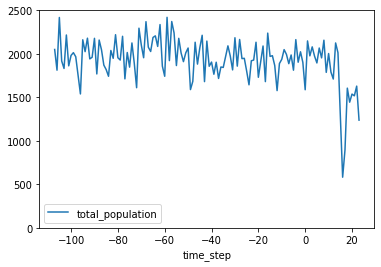

In [86]:
outflows_data.groupby('time_step').sum().plot(ylim=[0,2500])

In [90]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type'
]).count()[['Address']].reset_index().rename({'Address': 'total_population'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

for crime in crime_types:
    crime_recidivism = recidivism_transitions.copy()
    total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
    crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
    crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
    crime_recidivism = crime_recidivism.append({
        'compartment_duration': 36,
        'total_population': 1 - crime_specific_total_recidivism,
        'compartment': 'release',
        'outflow_to': 'release_full',
    }, ignore_index=True)
    crime_recidivism['crime_type'] = crime
    
    transitions_data = transitions_data.append(crime_recidivism)
    
    # adjust outflows so we're not double counting recidivism
    outflows_data.loc[
        outflows_data.crime_type == crime, 'total_population'
    ] /= 1 + crime_specific_total_recidivism


transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types),
    'total_population': [1] * len(crime_types),
    'compartment': ['release_full'] * len(crime_types),
    'outflow_to': ['release_full'] * len(crime_types),
    'crime_type': crime_types,
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,total_population,compartment,outflow_to
0,1.0,ARSON,142.0,prison,release
1,1.0,ASSAULT,6064.0,prison,release
2,1.0,BURGLARY,956.0,prison,release
3,1.0,CONSPIRACY,279.0,prison,release
4,1.0,DRUG_OTHER,1598.0,prison,release


In [93]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [95]:
simulation_tag = "insert_tag_here"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/test_configurations/walkthru_user_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Modeling

In [98]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/test_configurations/walkthru_user_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1852: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 2327 results
transitions_data returned 2957 results


crime_type            compartment  outflow_to
CAPITAL_MURDER        pretrial     prison        38.167939
SECOND_DEGREE_MURDER  pretrial     prison        48.854962
dtype: float64%


total_population_data returned 34 results


initialization time:  147.6432318687439


simulation_time:  121.68422794342041


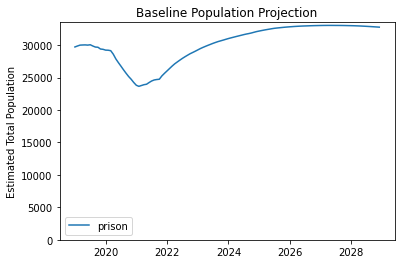

In [99]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

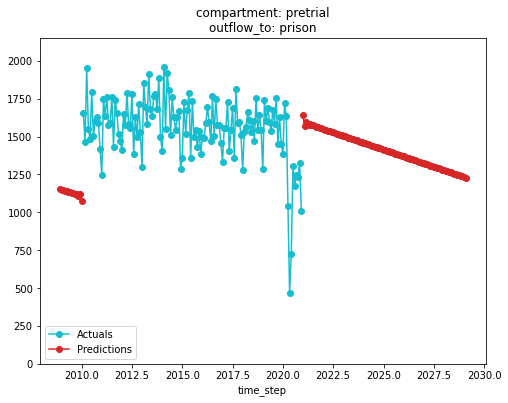

In [100]:
spark_sim.get_arima_output_plots('baseline_projections')

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  610.4994180202484


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  147.05187511444092


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

simulation_time:  76.11806297302246


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

simulation_time:  73.21955871582031


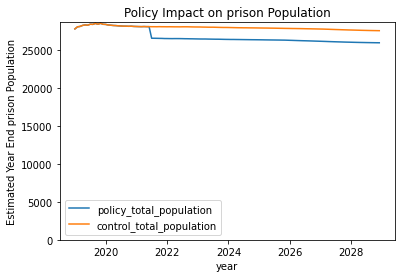

In [28]:
#REPLACE THIS WITH WHATEVER YOU'RE MODELING

# not actually using this yet, but I suspect moving people down ETC levels will be a more accurate handling
# for our next draft.
ETC_LEVEL_BY_CRIME = pd.DataFrame({
    'CONSPIRACY': {1:27, 2: 5, 3: 12, 4:7},
    'DRUG_POSSESSION': {1:574, 2:78, 3:177, 4:171},
    'DRUG_SALE': {1:1415, 2:245, 3:629, 4:458},
    'DRUG_OTHER': {1:1989, 2:323, 3:806, 4:629},
    'KIDNAPPING': {1:641, 2:203, 3:430, 4:304},
    'MANSLAUGHTER': {1:175, 2:44, 3:122, 4:96},
    'LARCENY': {1:1289, 2:190, 3:447, 4:591},
    'WEAPON': {1:346, 2:45, 3:100, 4:158},
    'ASSAULT': {1:1391, 2:354, 3:685, 4:728},
    'ROBBERY': {1:1491, 2:488, 3:1049, 4:1014},
    'BURGLARY': {1:740, 2:165, 3:413, 4:476},
    'DWI': {1: 101, 2: 14, 3: 28, 4:24},
    'RAPE': {1:1355, 2:304, 3:917, 4:405},
    'SEX_OFFENSE': {1:343, 2:60, 3:180, 4:80},
    'ARSON': {1:40, 2:13, 3:14, 4:26},
    'FIRST_DEGREE_MURDER': {1:868, 2:288, 3:534, 4:313},
    'SECOND_DEGREE_MURDER': {1:296, 2: 109, 3:224, 4:148},
    'OTHER_MURDER': {1:1327, 2:432, 3:833, 4:498},
    'CAPITAL_MURDER': {1:163, 2:35, 3:75, 4:37}
}).transpose()


# Note that I just use 0.85 as the new LOS in all cases. This is because we talked about doubling time off,
# but VA has a sentence reduction cap at 15%, so that'd just push everyone up to the cap.
def increase_ETCs(crime):
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': ['release'],
                       'reduction_size': [(LOS_BY_CRIME[crime] - 0.85) / LOS_BY_CRIME[crime]], 
                       'affected_fraction': [1]
                   }),
                   reduction_type='*',
                   retroactive=True)

policy_list = []
for crime in crime_types:
    policy_list.append(SparkPolicy(policy_fn=increase_ETCs(crime),
                                           spark_compartment='prison',
                                           sub_population={'crime_type': crime},
                                           policy_ts=30,
                                           apply_retroactive=True))



test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [4]:
simulation_tag = 'insert_tag_here'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release
 year                                
 2018.000000              0.0     0.0
 2018.083333              0.0     0.0
 2018.166667              0.0     0.0
 2018.250000              0.0     0.0
 2018.333333              0.0     0.0
 2018.416667              0.0     0.0
 2018.500000              0.0     0.0
 2018.583333              0.0     0.0
 2018.666667              0.0     0.0
 2018.750000              0.0     0.0
 2018.833333              0.0     0.0
 2018.916667              0.0     0.0
 2019.000000              0.0     0.0
 2019.083333              0.0     0.0
 2019.166667              0.0     0.0
 2019.250000              0.0     0.0
 2019.333333              0.0     0.0
 2019.416667              0.0     0.0
 2019.500000              0.0     0.0
 2019.583333              0.0     0.0
 2019.666667              0.0     0.0
 2019.750000              0.0     0.0
 2019.833333              0.0     0.0
 2019.916667              0.0    